<a href="https://colab.research.google.com/github/Chan99999/Section2_Project/blob/main/S2_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
#---------------------------------------------

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier


#---------------------------------------------
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score

#---------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns # heatmap
import mglearn
import joblib

import pydotplus
import os
import pandas as pd
import numpy as np
import pickle
import numpy as np
import json
import re 
import time
import ast
from pandas.io.json import json_normalize
import json

In [ ]:
# 데이터 업로드
from google.colab import files
uploaded = files.upload()

In [ ]:
win_data = pd.read_csv('match_winner_data_version1.csv')
lose_data = pd.read_csv('match_loser_data_version1.csv')
plus_data = pd.read_csv('new_match_chall+grand.csv')

In [ ]:
print(win_data['win'].unique())
print(lose_data['win'].unique())

# Nan값 제거
lose_data = lose_data.dropna(axis=0)

['Win']
['Fail' nan]


In [ ]:
win_data.sample(5)
lose_data.sample(5)

# 10만 게임중 서로다른 게임끼리 학습을 위해 분리
win_data = win_data[:50415]
lose_data = lose_data[50414:]

In [ ]:
# 데이터 결합
win_data.sample(5)
lose_data.sample(5)

lol_data = pd.merge(win_data,lose_data, how="outer")
lol_data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [ ]:
# 데이터 셔플
lol_data_shuffle = lol_data.sample(frac=1).reset_index(drop=True)

# 데이터 전처리 불필요한 열 제거
lol_data_shuffle = lol_data_shuffle.drop(['bans','gameId'], axis = 1)

# 추가 데이터 전처리 불필요한 열 제거
plus_data = plus_data.drop(['gameId'],axis = 1)

In [ ]:
# 데이터 전처리과정
lol_data_shuffle = lol_data_shuffle.drop(['teamId','dominionVictoryScore','vilemawKills'],axis = 1)
plus_data = plus_data.drop(['teamId'],axis = 1)

lol_data_shuffle = lol_data_shuffle.replace('Win',1)
lol_data_shuffle = lol_data_shuffle.replace('Fail',0)
plus_data = plus_data.replace('Win',1)
plus_data = plus_data.replace('Fail',0)

In [ ]:
# 추가 데이터(약 7만개) + 기존 데이터(약 11만개)
add_data = pd.concat([lol_data_shuffle,plus_data], ignore_index = True)

In [ ]:
## 데이터 통계

# 첫번째 킬한 상황
win_kill_data = add_data[add_data['win']==1.0]['firstBlood']
win_firstblood = win_kill_data.value_counts(normalize=True)

lose_kill_data = add_data[add_data['win']==0.0]['firstBlood']
# print(data2.value_counts(normalize=True))
lose_firstblood = lose_kill_data.value_counts(normalize=True)

# print('Game win : \n',win_firstblood)
# print('Game lose : \n',lose_firstblood)


# 첫번째 타워 먹은 상황
win_tower_data = add_data[add_data['win']==1.0]['firstTower']
win_firsttower = win_tower_data.value_counts(normalize=True)

lose_tower_data = add_data[add_data['win']==0.0]['firstTower']
lose_firsttower = lose_tower_data.value_counts(normalize=True)


# 첫번째 억제기 먹은 상황
win_inhib_data = add_data[add_data['win']==1.0]['firstInhibitor']
win_Inhibit = win_inhib_data.value_counts(normalize=True)

lose_inhib_data = add_data[add_data['win']==0.0]['firstInhibitor']
lose_Inhibit = lose_inhib_data.value_counts(normalize=True)
# print(win_Inhibit)
# print(lose_Inhibit)
# 첫번째 바론 먹은 상황
win_baron_data = add_data[add_data['win']==1.0]['firstBaron']
win_firstbaron = win_baron_data.value_counts(normalize=True)

lose_baron_data = add_data[add_data['win']==0.0]['firstBaron']
lose_firstbaron = lose_baron_data.value_counts(normalize=True)


# 첫번째 용 먹은 상황
win_dragon_data = add_data[add_data['win']==1.0]['firstDragon']
win_firstdragon = win_dragon_data.value_counts(normalize=True)

lose_dragon_data = add_data[add_data['win']==0.0]['firstDragon']
lose_firstdragon = lose_dragon_data.value_counts(normalize=True)


# 첫번째 전령 먹은 상황
win_riftherald_data = add_data[add_data['win']==1.0]['firstRiftHerald']
win_firstriftherald = win_riftherald_data.value_counts(normalize=True)

lose_riftherald_data = add_data[add_data['win']==0.0]['firstRiftHerald']
lose_firstriftherald = lose_riftherald_data.value_counts(normalize=True)


print("0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우")
data_weight = pd.DataFrame({'WinGame_Firstkill':[win_firstblood[0],win_firstblood[1]],
                           'LoseGame_Firstkill':[lose_firstblood[0],lose_firstblood[1]],
                           
                            'WinGame_firsttower':[win_firsttower[0],win_firsttower[1]],
                           'LoseGame_firsttower':[lose_firsttower[0],lose_firsttower[1]],
                         
                            'WinGame_firstInhibit':[win_Inhibit[0],win_Inhibit[1]],
                           'LoseGame_firstInhibit':[lose_Inhibit[0],lose_Inhibit[1]],
                          
                            'WinGame_firstbaron':[win_firstbaron[0],win_firstbaron[1]],
                           'LoseGame_firstbaron':[lose_firstbaron[0],lose_firstbaron[1]],
                            
                           'WinGame_firstdragon':[win_firstdragon[0],win_firstdragon[1]],
                           'LoseGame_firstdragon':[lose_firstdragon[0],lose_firstdragon[1]],
                         
                            'WinGame_firstriftherald':[win_firstriftherald[0],win_firstriftherald[1]],
                           'LoseGame_firstriftherald':[lose_firstriftherald[0],lose_firstriftherald[1]],
                           })

print(data_weight)
a = np.array(data_weight)
print(a[0])
print(a[1])

0은 오브젝트를 못먹은 경우, 1은 오브젝트를 먹은 경우
   WinGame_Firstkill  LoseGame_Firstkill  WinGame_firsttower  \
0           0.396899            0.601059            0.260374   
1           0.603101            0.398941            0.739626   

   LoseGame_firsttower  WinGame_firstInhibit  LoseGame_firstInhibit  \
0             0.732654               0.31526               0.940678   
1             0.267346               0.68474               0.059322   

   WinGame_firstbaron  LoseGame_firstbaron  WinGame_firstdragon  \
0            0.579118             0.914322             0.448931   
1            0.420882             0.085678             0.551069   

   LoseGame_firstdragon  WinGame_firstriftherald  LoseGame_firstriftherald  
0              0.712084                 0.404461                  0.679182  
1              0.287916                 0.595539                  0.320818  
[0.396899   0.60105944 0.26037431 0.73265381 0.31526004 0.94067778
 0.57911821 0.914322   0.44893106 0.71208371 0.40446125 0.679

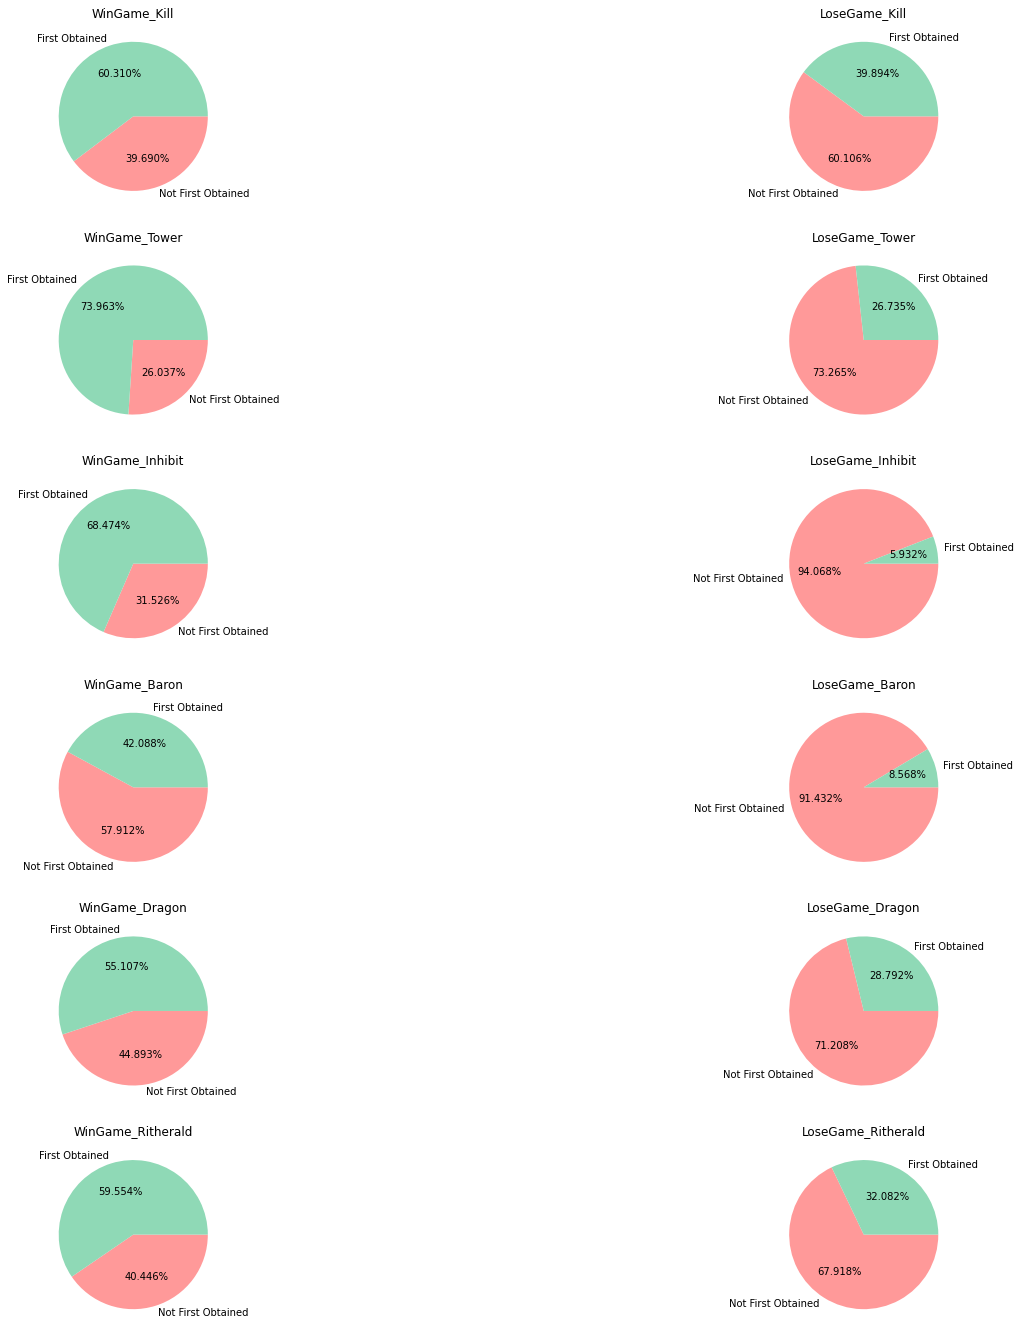

In [ ]:
# 데이터 시각화

# 총 17만개의 게임경기 데이터
colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First Obtained','First Obtained'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Kill")
axes[0][1].set_title("LoseGame_Kill")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

정확도 :  0.8718152414458378


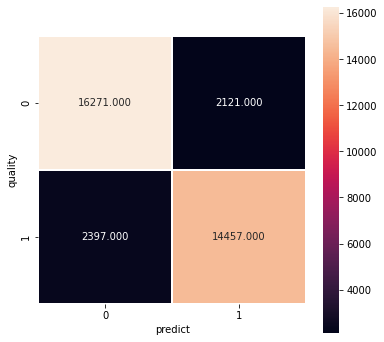

5 폴드세트 0.8721074083864291
6 폴드세트 0.8724422048959858
7 폴드세트 0.8726464924835245
8 폴드세트 0.8727089258622334
9 폴드세트 0.8729188872095691
10 폴드세트 0.872998324798577
11 폴드세트 0.8733501801215945
12 폴드세트 0.8729358909270756
13 폴드세트 0.872941522462011
14 폴드세트 0.8732196052205508


In [ ]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

add_data = add_data.replace(True,1)
add_data = add_data.replace(False,0)

train_x = np.array(pd.DataFrame(add_data, columns=['firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald',
                                                          'towerKills','inhibitorKills','baronKills','dragonKills','riftHeraldKills']))  

train_y = np.array(pd.DataFrame(add_data, columns=['win'])) 

train_x = train_x.astype(np.int64)
train_y = train_y.astype(np.int64)


X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=36)

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(X_train, Y_train)
df_prediction = dt_clf.predict(X_test)

print("정확도 : ", accuracy_score(Y_test,df_prediction))

conf_mat = confusion_matrix(Y_test,df_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()


for i in range(5,15):
    kf = StratifiedKFold(n_splits=i, shuffle = True)
    score = cross_val_score(dt_clf, train_x, train_y, cv = kf, scoring="accuracy")
    print(i,"폴드세트",score.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was

0.8786501400001306
정확도 :  0.8791635930318334


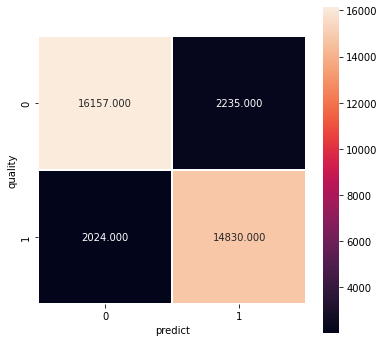

In [ ]:
forest=RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf = 3, min_samples_split = 10)

forest.fit(X_train, Y_train)

forest_prediction = forest.predict(X_test)


kf = StratifiedKFold(n_splits=5, shuffle = True)
score = cross_val_score(forest, train_x, train_y, cv = kf, scoring="accuracy")
print(score.mean())

print("정확도 : ", accuracy_score(Y_test,forest_prediction))

conf_mat = confusion_matrix(Y_test,forest_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()

In [114]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

params = {
      'n_estimators' : [100,300,500],
      'max_depth' : [6,8,10,12],
      'min_samples_leaf' : [3,5,7,10],
      'min_samples_split' : [3,5,10]
  }

forest_grid = GridSearchCV(forest, param_grid = params, scoring="accuracy", n_jobs=-1, verbose =1)

forest_grid.fit(X_train, Y_train)

ValueError: ignored

In [83]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
print('최적 하이퍼파라미터: ', grid.best_params_)
y_pred = grid.predict(X_test)
print('검증 정확도:', grid.best_score_)
print('F1:',f1_score(Y_test, y_pred))

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__n_estimators': 80}
검증 정확도: nan
F1: 0.8517944510286565


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도: 0.858
테스트 세트 정확도: 0.859
정확도 :  0.859019463201498


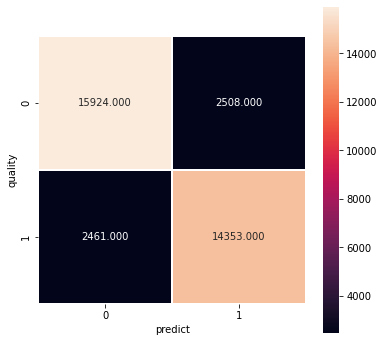

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=48)

gbrt = GradientBoostingClassifier(random_state=48,learning_rate = 0.01)
gbrt.fit(X_train, Y_train)

gbrt_prediction = gbrt.predict(X_test)

print("훈련 세트 정확도: {:.3f}".format(gbrt.score(X_train, Y_train)))
print("테스트 세트 정확도: {:.3f}".format(gbrt.score(X_test, Y_test)))

print("정확도 : ", accuracy_score(Y_test,gbrt_prediction))

conf_mat = confusion_matrix(Y_test,gbrt_prediction)

plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("quality")
plt.xlabel("predict")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


정확도 :  0.870992453044317
[[15882  2550]
 [ 1997 14817]]


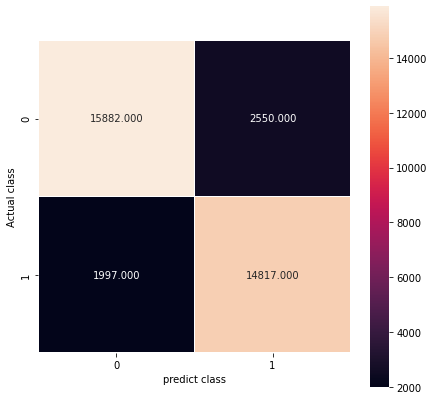

In [69]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=48)

#xgb = XGBClassifier(n_estimators = 300, learning_rate = 1, max_depth = 4)
xgb = XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=1, max_delta_step=0,
                                     max_depth=4, min_child_weight=1, monotone_constraints='()',
                                     n_estimators=300, n_jobs=48,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None)

xgb = XGBClassifier()
evals = [(X_test,Y_test)]

#xgb.fit(X_train, Y_train, early_stopping_rounds = 100, eval_metric='logloss', eval_set = evals, verbose=True)
xgb.fit(X_train, Y_train)

y_pred = xgb.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show()

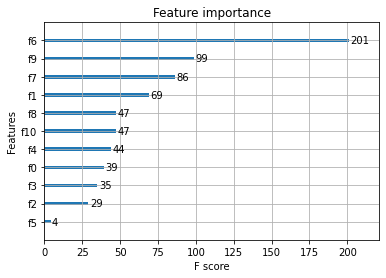

In [70]:
from xgboost import XGBClassifier, plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax = ax)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.356959	valid_0's binary_logloss: 0.356959
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's binary_logloss: 0.321988	valid_0's binary_logloss: 0.321988
[3]	valid_0's binary_logloss: 0.313053	valid_0's binary_logloss: 0.313053
[4]	valid_0's binary_logloss: 0.308265	valid_0's binary_logloss: 0.308265
[5]	valid_0's binary_logloss: 0.305017	valid_0's binary_logloss: 0.305017
[6]	valid_0's binary_logloss: 0.304331	valid_0's binary_logloss: 0.304331
[7]	valid_0's binary_logloss: 0.30196	valid_0's binary_logloss: 0.30196
[8]	valid_0's binary_logloss: 0.301102	valid_0's binary_logloss: 0.301102
[9]	valid_0's binary_logloss: 0.299539	valid_0's binary_logloss: 0.299539
[10]	valid_0's binary_logloss: 0.299026	valid_0's binary_logloss: 0.299026
[11]	valid_0's binary_logloss: 0.298401	valid_0's binary_logloss: 0.298401
[12]	valid_0's binary_logloss: 0.299256	valid_0's binary_logloss: 0.299256
[13]	valid_0's binary_logloss: 0.298294	valid_0's

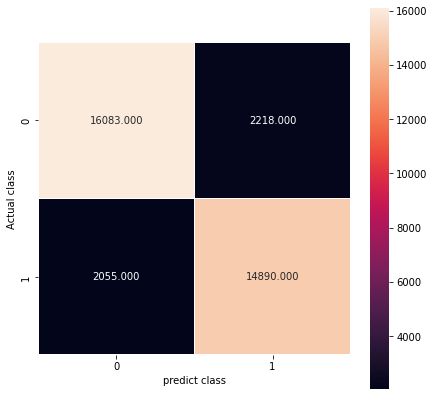

In [67]:
from lightgbm import LGBMClassifier, plot_importance

X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.20, random_state=42)

lgb = LGBMClassifier(n_estimators = 300, learning_rate = 1, max_depth = 4)
evals = [(X_test,Y_test)]
lgb.fit(X_train, Y_train, early_stopping_rounds = 50, eval_metric='logloss', eval_set = evals, verbose=True)

y_pred = lgb.predict(X_test)

accuracy_score(Y_test,y_pred)
print("정확도 : ",accuracy_score(Y_test,y_pred))

conf_mat = confusion_matrix(Y_test,y_pred)
print(confusion_matrix(Y_test,y_pred))

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat, annot = True, fmt=".3f", linewidths=.5,square=True)
plt.ylabel("Actual class")
plt.xlabel("predict class")
plt.show();

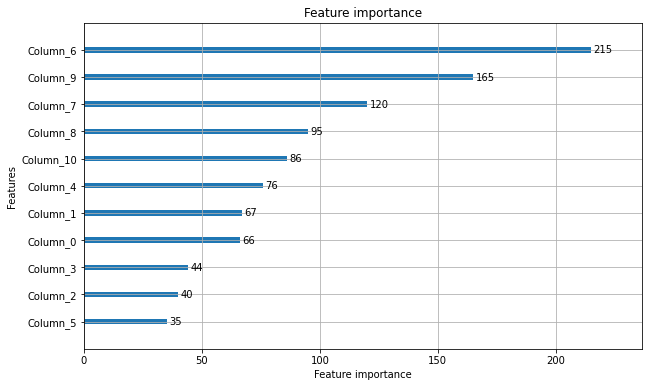

In [68]:
fig, ax = plt.subplots(figsize = (10,6))
plot_importance(lgb, ax = ax)

In [ ]:
# 실제 내가 실행한 게임을 대입해 예측
# 킬 타워 억제기 바론 용 전령 타워수 억제기수 바론수 용수 전령수

game1 = np.array([[0,1,0,0,1,1,4,0,0,1,1]]) # 총 게임시간 20분 보다 7분 빠르게 승리예측 성공
game2 = np.array([[0,0,0,1,1,1,4,0,1,2,2]]) # 예측 실패 
game3 = np.array([[0,0,0,0,1,0,1,0,0,1,0]]) # 총 20분 게임 패배예측 성공
game4 = np.array([[0,1,0,0,1,0,2,0,0,2,0]]) # 총 게임시간 16분 보다 2분빠르게 예측
game5 = np.array([[1,0,0,0,0,0,6,1,0,3,0]]) # 총 게임시간 43분 보다 10분빠르게 승리예측


game1_result = xgb.predict(game1)
game2_result = xgb.predict(game2)
game3_result = xgb.predict(game3)
game4_result = xgb.predict(game4)
game5_result = xgb.predict(game5)

print("1승리, 0패배: ",game1_result)
print("1승리, 0패배: ",game2_result)
print("1승리, 0패배: ",game3_result)
print("1승리, 0패배: ",game4_result)
print("1승리, 0패배: ",game5_result)

1승리, 0패배:  [1]
1승리, 0패배:  [1]
1승리, 0패배:  [0]
1승리, 0패배:  [0]
1승리, 0패배:  [1]
